In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from google.colab import drive

# --- Import tambahan untuk metrik, plotting, dan progress bar ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.auto import tqdm # <-- IMPORT PENTING UNTUK PROGRESS BAR

# --- 1. Konfigurasi dan Hiperparameter ---

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {DEVICE}")

Menggunakan device: cuda


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32 # Sesuaikan jika perlu
LR_FEATURE_EXTRACTION = 1e-3
LR_FINE_TUNING = 1e-5

EPOCHS_FEATURE_EXTRACTION = 3 # Epoch pemanasan untuk head
MAX_EPOCHS_FINE_TUNING = 100  # Epoch maksimal untuk fine-tuning
EARLY_STOPPING_PATIENCE = 10  # Jumlah epoch untuk menunggu jika tidak ada peningkatan

# --- Mount Google Drive (KHUSUS COLAB) ---

In [ ]:
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted.")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.


# --- 2. Memuat Data Anda Menggunakan ImageFolder ---

In [ ]:
DATA_DIR = '/content/drive/MyDrive/train_with_label'

In [ ]:
transform_train = transforms.Compose([
    # Prioritas #1: Augmentasi Geometris (Sangat Aman & Efektif)
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),

    # Prioritas #2: Augmentasi Warna yang "Aman"
    # Kita hanya bermain di brightness dan contrast (simulasi pencahayaan)
    # Kita kurangi saturasi dan HUE (yang paling berisiko)
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1, hue=0.05),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Cukup resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
full_dataset = ImageFolder(root=DATA_DIR)
print(f"Dataset dimuat. Ditemukan {len(full_dataset)} gambar.")

Dataset dimuat. Ditemukan 3953 gambar.


In [ ]:
class_names = full_dataset.classes
NUM_CLASSES = len(class_names)
print(f"Ditemukan {NUM_CLASSES} kelas: {class_names}")

Ditemukan 15 kelas: ['Ayam Bakar', 'Ayam Betutu', 'Ayam Goreng', 'Ayam Pop', 'Bakso', 'Coto Makassar', 'Gado Gado', 'Gudeg', 'Nasi Goreng', 'Pempek', 'Rawon', 'Rendang', 'Sate Madura', 'Sate Padang', 'Soto']


In [ ]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
print(f"Total data: {len(full_dataset)}")
print(f"Data latih: {len(train_dataset)}")
print(f"Data validasi: {len(val_dataset)}")

Total data: 3953
Data latih: 3162
Data validasi: 791


In [ ]:
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- 3. Memuat Model Pre-trained ViT ---

In [ ]:
print("\nMemuat model ViT pre-trained...")
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)


Memuat model ViT pre-trained...


# --- 4. Tahap 1: Feature Extraction (dengan TQDM) ---

## Bekukan semua parameter di base model

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
in_features = model.heads.head.in_features
model.heads.head = nn.Sequential(
    nn.Dropout(p=0.5),  # Tambahkan Dropout dengan p=0.5 (nilai umum)
    nn.Linear(in_features, NUM_CLASSES)
)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR_FINE_TUNING, weight_decay=1e-4)

In [ ]:
for epoch in range(EPOCHS_FEATURE_EXTRACTION):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    # Bungkus train_loader dengan tqdm
    loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS_FEATURE_EXTRACTION}")

    for inputs, labels in loop:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Hitung akurasi
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Update progress bar
        loop.set_postfix(
            loss=(running_loss / (loop.n + 1)),
            accuracy=(running_correct / running_total)
        )

print('Tahap 1 Selesai.')

Epoch 1/3:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/99 [00:00<?, ?it/s]

Tahap 1 Selesai.


# --- 5. Tahap 2: Fine-Tuning (dengan TQDM dan Early Stopping) ---

In [ ]:
print("\n--- Memulai Pelatihan Tahap 2 (Fine-Tuning) ---")

for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=LR_FINE_TUNING)

best_val_loss = float('inf')
patience_counter = 0
best_epoch = 0

for epoch in range(MAX_EPOCHS_FINE_TUNING):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    running_train_correct = 0
    running_train_total = 0

    # Bungkus train_loader dengan tqdm
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{MAX_EPOCHS_FINE_TUNING} [Train]", leave=False)

    for inputs, labels in train_loop:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_train_total += labels.size(0)
        running_train_correct += (predicted == labels).sum().item()

        # Update progress bar training
        train_loop.set_postfix(
            loss=(running_train_loss / (train_loop.n + 1)),
            accuracy=(running_train_correct / running_train_total)
        )

    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_acc = running_train_correct / running_train_total

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0

    # Bungkus val_loader dengan tqdm
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{MAX_EPOCHS_FINE_TUNING} [Val]", leave=False)

    with torch.no_grad():
        for inputs, labels in val_loop:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_val_total += labels.size(0)
            running_val_correct += (predicted == labels).sum().item()

            # Update progress bar validasi
            val_loop.set_postfix(
                val_loss=(running_val_loss / (val_loop.n + 1)),
                val_accuracy=(running_val_correct / running_val_total)
            )

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_acc = running_val_correct / running_val_total

    # Cetak ringkasan epoch (mirip Keras)
    # Anda bisa mengatur format string ini sesuai keinginan
    print(f"Epoch {epoch + 1}/{MAX_EPOCHS_FINE_TUNING} - "
          f"loss: {avg_train_loss:.4f} - accuracy: {avg_train_acc:.4f} - "
          f"val_loss: {avg_val_loss:.4f} - val_accuracy: {avg_val_acc:.4f}")

    # --- Logika Early Stopping ---
    if avg_val_loss < best_val_loss:
        print(f'   Val loss membaik ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Menyimpan model...')
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        best_epoch = epoch + 1
    else:
        patience_counter += 1
        print(f'   Val loss tidak membaik. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}')

    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f'Early stopping dipicu pada epoch {epoch + 1}!')
        break

print(f'Tahap 2 Selesai. Model terbaik disimpan dari epoch {best_epoch}.')


--- Memulai Pelatihan Tahap 2 (Fine-Tuning) ---


Epoch 1/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/100 - loss: 0.4624 - accuracy: 0.8722 - val_loss: 0.6052 - val_accuracy: 0.8129
   Val loss membaik (inf --> 0.6052). Menyimpan model...


Epoch 2/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/100 - loss: 0.3017 - accuracy: 0.9187 - val_loss: 0.5542 - val_accuracy: 0.8268
   Val loss membaik (0.6052 --> 0.5542). Menyimpan model...


Epoch 3/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/100 - loss: 0.2052 - accuracy: 0.9459 - val_loss: 0.5671 - val_accuracy: 0.8255
   Val loss tidak membaik. Patience: 1/10


Epoch 4/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/100 - loss: 0.1515 - accuracy: 0.9633 - val_loss: 0.5628 - val_accuracy: 0.8293
   Val loss tidak membaik. Patience: 2/10


Epoch 5/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 5/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
 
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers() 
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    if w.is_alive():^
^^ ^ ^^  ^^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^ ^ ^ ^ ^^ ^      File "/usr/l

Epoch 5/100 - loss: 0.1059 - accuracy: 0.9807 - val_loss: 0.5518 - val_accuracy: 0.8458
   Val loss membaik (0.5542 --> 0.5518). Menyimpan model...


Epoch 6/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6/100 - loss: 0.0747 - accuracy: 0.9899 - val_loss: 0.5500 - val_accuracy: 0.8268
   Val loss membaik (0.5518 --> 0.5500). Menyimpan model...


Epoch 7/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/100 - loss: 0.0582 - accuracy: 0.9899 - val_loss: 0.5449 - val_accuracy: 0.8344
   Val loss membaik (0.5500 --> 0.5449). Menyimpan model...


Epoch 8/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8/100 - loss: 0.0468 - accuracy: 0.9927 - val_loss: 0.5909 - val_accuracy: 0.8357
   Val loss tidak membaik. Patience: 1/10


Epoch 9/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/100 - loss: 0.0311 - accuracy: 0.9978 - val_loss: 0.5759 - val_accuracy: 0.8319
   Val loss tidak membaik. Patience: 2/10


Epoch 10/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 10/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10/100 - loss: 0.0290 - accuracy: 0.9962 - val_loss: 0.5989 - val_accuracy: 0.8217
   Val loss tidak membaik. Patience: 3/10


Epoch 11/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 11/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()    Exception ignored in: 
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():Traceback (most recent call last):
    
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
if w.is

Epoch 11/100 - loss: 0.0244 - accuracy: 0.9975 - val_loss: 0.5819 - val_accuracy: 0.8319
   Val loss tidak membaik. Patience: 4/10


Epoch 12/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12/100 - loss: 0.0193 - accuracy: 0.9975 - val_loss: 0.5994 - val_accuracy: 0.8369
   Val loss tidak membaik. Patience: 5/10


Epoch 13/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 13/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13/100 - loss: 0.0185 - accuracy: 0.9972 - val_loss: 0.6152 - val_accuracy: 0.8394
   Val loss tidak membaik. Patience: 6/10


Epoch 14/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 14/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14/100 - loss: 0.0145 - accuracy: 0.9984 - val_loss: 0.6143 - val_accuracy: 0.8369
   Val loss tidak membaik. Patience: 7/10


Epoch 15/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 15/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15/100 - loss: 0.0141 - accuracy: 0.9981 - val_loss: 0.6065 - val_accuracy: 0.8420
   Val loss tidak membaik. Patience: 8/10


Epoch 16/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 16/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16/100 - loss: 0.0140 - accuracy: 0.9978 - val_loss: 0.6114 - val_accuracy: 0.8331
   Val loss tidak membaik. Patience: 9/10


Epoch 17/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 17/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220><function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7915601cc220>Exception ignored in:     
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
         se

Epoch 17/100 - loss: 0.0129 - accuracy: 0.9978 - val_loss: 0.6386 - val_accuracy: 0.8369
   Val loss tidak membaik. Patience: 10/10
Early stopping dipicu pada epoch 17!
Tahap 2 Selesai. Model terbaik disimpan dari epoch 7.


# --- 6. Evaluasi Model (Laporan & Confusion Matrix) ---


--- Evaluasi Model Final (dari best_model.pth) ---
Akurasi pada 791 gambar validasi: 85.59 %
----------------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

   Ayam Bakar       0.86      0.89      0.88        36
  Ayam Betutu       0.86      0.86      0.86        43
  Ayam Goreng       0.80      0.81      0.81        70
     Ayam Pop       0.74      0.88      0.81        68
        Bakso       0.91      0.86      0.88        70
Coto Makassar       0.79      0.68      0.73        40
    Gado Gado       0.83      0.88      0.85        50
        Gudeg       0.94      0.74      0.83        46
  Nasi Goreng       0.96      0.93      0.95        58
       Pempek       0.92      0.83      0.87        53
        Rawon       0.86      0.88      0.87        67
      Rendang       0.82      0.86      0.84        42
  Sate Madura       0.93      0.84      0.88        45
  Sate Padang       0.87      0.93      0

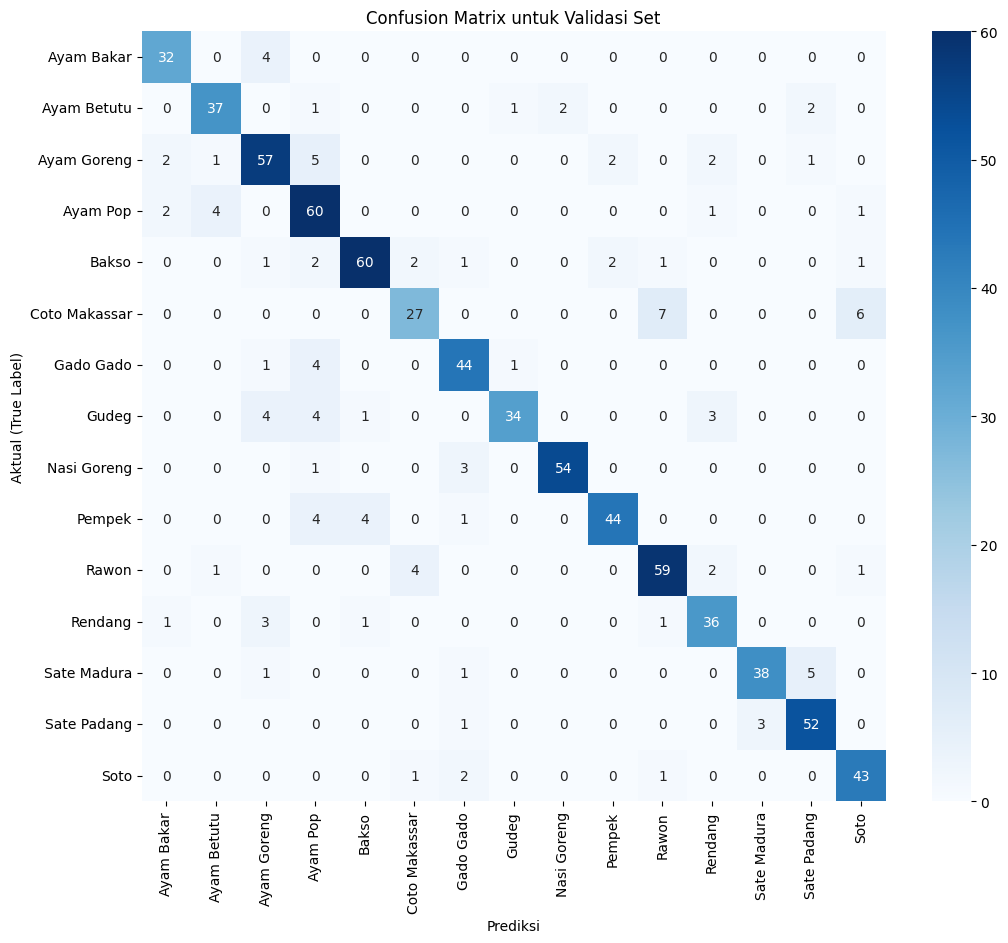

In [ ]:
# --- 6. Evaluasi Model (Laporan & Confusion Matrix) ---
# (Bagian ini tetap sama, tidak perlu diubah)
print("\n--- Evaluasi Model Final (dari best_model.pth) ---")

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_labels = []
all_preds = []
correct = 0
total = 0

with torch.no_grad():
    for data in val_loader: # Menggunakan val_loader untuk evaluasi
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# 1. Cetak Akurasi Keseluruhan
accuracy = 100 * correct / total
print(f'Akurasi pada {total} gambar validasi: {accuracy:.2f} %')
print("-" * 70)

# 2. Cetak Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print("-" * 70)

# 3. Buat dan Tampilkan Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Aktual (True Label)')
plt.title('Confusion Matrix untuk Validasi Set')
plt.show()

# Prediksi (Inference)

In [ ]:
import os
import glob
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm

TEST_DIR = '/content/drive/MyDrive/test/test'
CSV_OUTPUT_PATH = '/content/drive/MyDrive/submission.csv'

# --- 2. Transformasi untuk Validasi/Tes ---
# (Tanpa augmentasi, hanya resize dan normalisasi)
transform_val = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- 3. Custom Dataset untuk Folder Tes ---
# Dataset ini memuat gambar dari folder datar (tanpa sub-folder label)

from torch.utils.data import Dataset # Import Dataset class
class CustomTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        # Cari semua file gambar (jpg, jpeg, png)
        self.img_paths = glob.glob(os.path.join(img_dir, '*.jpg')) + \
                         glob.glob(os.path.join(img_dir, '*.jpeg')) + \
                         glob.glob(os.path.join(img_dir, '*.png'))
        self.transform = transform

        if not self.img_paths:
            print(f"Peringatan: Tidak ada gambar .jpg, .jpeg, atau .png yang ditemukan di {img_dir}")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]

        # Buka gambar
        image = Image.open(img_path).convert('RGB')

        # Terapkan transformasi
        if self.transform:
            image = self.transform(image)

        # Ekstrak ID (nama file tanpa ekstensi)
        # misal: '/content/drive/MyDrive/test/1.jpg' -> '1'
        file_id = os.path.splitext(os.path.basename(img_path))[0]

        return image, file_id

# --- 4. Memuat Data Tes ---
print(f"Memuat data tes dari: {TEST_DIR}")
test_dataset = CustomTestDataset(img_dir=TEST_DIR, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) # Set num_workers to 0 to avoid multiprocessing issues

print(f"Ditemukan {len(test_dataset)} gambar untuk diprediksi.")

# --- 5. Memuat Model yang Sudah Dilatih ---
print("Memuat model 'best_model.pth'...")

# Asumsi: Variabel NUM_CLASSES dan class_names ADA dari sel sebelumnya
# Jika tidak, Anda harus mendefinisikannya secara manual di sini, contoh:
# NUM_CLASSES = 16
# class_names = ['Ayam Bakar', 'Ayam Betutu', ...]

if 'NUM_CLASSES' not in locals():
    print("Error: Variabel 'NUM_CLASSES' tidak ditemukan. Jalankan sel pelatihan dulu.")
else:
    # 1. Buat ulang arsitektur model (MATCHING THE SAVED MODEL)
    model = models.vit_b_16(weights=None) # Tidak perlu weights pre-trained, kita akan load
    in_features = model.heads.head.in_features

    # 2. Buat ulang head klasifikasi (MATCHING THE SAVED MODEL - WITHOUT nn.Sequential)
    # Based on the error, it seems the saved model did NOT have the nn.Sequential wrapper.
    model.heads.head = nn.Linear(in_features, NUM_CLASSES)


    # 3. Muat bobot (weights) terbaik yang disimpan
    try:
        model.load_state_dict(torch.load('best_model.pth'))
        print("Model berhasil dimuat.")
    except RuntimeError as e:
        print(f"Error loading state_dict: {e}")
        print("Attempting to load with strict=False to handle potential key mismatches.")
        # This might happen if the saved state_dict has slight variations
        model.load_state_dict(torch.load('best_model.pth'), strict=False)
        print("Model loaded with strict=False.")

    model = model.to(DEVICE)
    model.eval() # PENTING: Set model ke mode evaluasi


    # --- 6. Melakukan Prediksi ---
    results = []

    with torch.no_grad(): # Matikan gradien untuk inferensi
        for images, file_ids in tqdm(test_loader, desc="Melakukan Prediksi"):
            images = images.to(DEVICE)

            # Dapatkan output model
            outputs = model(images)

            # Dapatkan prediksi (indeks dengan nilai tertinggi)
            _, predicted_indices = torch.max(outputs.data, 1)

            # Ubah indeks ke nama kelas
            predicted_labels = [class_names[i] for i in predicted_indices]

            # Simpan hasil (ID file dan label prediksi)
            for i in range(len(file_ids)):
                results.append([file_ids[i], predicted_labels[i]])

    # --- 7. Menyimpan Hasil ke CSV ---
    print("Prediksi selesai. Menyimpan ke CSV...")

    # Buat DataFrame Pandas dari hasil
    df = pd.DataFrame(results, columns=['ID', 'label'])

    # Urutkan berdasarkan ID (jika ID-nya adalah angka)
    # Ini membantu jika ID-nya '1', '10', '2' agar menjadi '1', '2', '10'
    try:
        df['ID_num'] = df['ID'].astype(int)
        df = df.sort_values(by='ID_num').drop(columns=['ID_num'])
    except ValueError:
        # Jika ID bukan angka (misal: 'img_a', 'img_b'), urutkan berdasarkan alfabet
        df = df.sort_values(by='ID')

    # Simpan ke file CSV
    df.to_csv(CSV_OUTPUT_PATH, index=False)

    print(f"Berhasil! Hasil prediksi disimpan di: {CSV_OUTPUT_PATH}")

    # Tampilkan 5 baris pertama dari hasil
    print("\nContoh 5 baris pertama dari hasil:")
    print(df.head())

Memuat data tes dari: /content/drive/MyDrive/test/test
Ditemukan 2057 gambar untuk diprediksi.
Memuat model 'best_model.pth'...
Model berhasil dimuat.


Melakukan Prediksi:   0%|          | 0/65 [00:00<?, ?it/s]

Prediksi selesai. Menyimpan ke CSV...
Berhasil! Hasil prediksi disimpan di: /content/drive/MyDrive/submission.csv

Contoh 5 baris pertama dari hasil:
      ID        label
91  0001  Sate Padang
79  0002  Nasi Goreng
76  0003  Ayam Goreng
85  0004      Rendang
88  0005  Ayam Goreng
